In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
class Lucas_Kanade:
    def __init__(self, old_frame_path, new_frame_path):
        self.old_frame = cv2.imread(old_frame_path, cv2.IMREAD_GRAYSCALE)
        self.new_frame = cv2.imread(new_frame_path, cv2.IMREAD_GRAYSCALE)
        self.color_frame = cv2.imread(new_frame_path)
    
    #  inRange checks whether the given cordinates line in the given image limits
    #  cordinates, limits are tuples i.e., (X,Y) 
    def in_range(self, coordinates, limits):
        x, y = coordinates
        X_Limit, Y_Limit = limits
        return 0 <= x < X_Limit and 0 <= y < Y_Limit

    
    # opticalFlow calculates the displacements in X and Y directions i.e., (u,v)
    # given two consecutive images varying with time
    def optical_flow(self, window_size, min_quality=0.01):
        max_corners = 10000
        min_distance = 0.1
        feature_list = cv2.goodFeaturesToTrack(self.old_frame, max_corners, min_quality, min_distance)

        w = int(window_size / 2)

        old_frame = self.old_frame / 255.0
        new_frame = self.new_frame / 255.0
        
        #Convolve to get gradients w.r.to X, Y and T dimensions
        kernel_x = np.array([[-1, 1], [-1, 1]])
        kernel_y = np.array([[-1, -1], [1, 1]])
        kernel_t = np.array([[1, 1], [1, 1]])

        fx = cv2.filter2D(old_frame, -1, kernel_x)  #Gradient over X
        fy = cv2.filter2D(old_frame, -1, kernel_y)   #Gradient over Y
        ft = cv2.filter2D(new_frame, -1, kernel_t) - cv2.filter2D(old_frame, -1, kernel_t)    #Gradient over T

        u = np.zeros(old_frame.shape)
        v = np.zeros(old_frame.shape)

        for feature in feature_list:
            j, i = feature.ravel()
            i, j = int(i), int(j)

            I_x = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            I_y = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            I_t = ft[i-w:i+w+1, j-w:j+w+1].flatten()

            b = np.reshape(I_t, (I_t.shape[0], 1))
            A = np.vstack((I_x, I_y)).T

            U = np.matmul(np.linalg.pinv(A), b)

            u[i, j] = U[0][0]
            v[i, j] = U[1][0]

        return u, v

    
    # Draw the displacement vectors on the image, given (u,v) and save it to the output filepath provided
    def draw_on_frame(self, U, V):
        frame = self.color_frame.copy()
        for i in range(frame.shape[0]):
            for j in range(frame.shape[1]):
                u, v = U[i][j], V[i][j]
                if u and v:
                    frame = cv2.arrowedLine(frame, (j, i), (int(round(j+v)), int(round(i+u))),
                                            (0, 255, 0), thickness=1)
        return frame

    
    # Create a plot of the displacement vectors given (u,v) and plot the two images and displacement in a row.
    def draw_separately(self, U, V):
        displacement = np.ones_like(self.new_frame) * 255
        line_color = (0, 0, 0) #Fill the displacement plot with White background
        for i in range(self.new_frame.shape[0]):
            for j in range(self.new_frame.shape[1]):
                start_pixel = (j, i)
                end_pixel = (int(j+V[i][j]), int(i+U[i][j]))
                #check if there is displacement for the corner and endpoint is in range
                if U[i][j] and V[i][j] and self.in_range(end_pixel, self.old_frame.shape):
                    displacement = cv2.arrowedLine(displacement, start_pixel, end_pixel, line_color, thickness=2)

        figure, axes = plt.subplots(1, 3)
        axes[0].imshow(self.old_frame, cmap="gray")
        axes[0].set_title("First Image")
        axes[1].imshow(self.new_frame, cmap="gray")
        axes[1].set_title("Second Image")
        axes[2].imshow(displacement, cmap="gray")
        axes[2].set_title("Displacements")
        figure.tight_layout()
        plt.show()

    def process_and_display(self, window_size, min_quality):
        U, V = self.optical_flow(window_size, min_quality)
        drawn_frame = self.draw_on_frame(U, V)
        plt.imshow(cv2.cvtColor(drawn_frame, cv2.COLOR_BGR2RGB))
        plt.title("Optical Flow on Frame")
        plt.show()
        self.draw_separately(U, V)

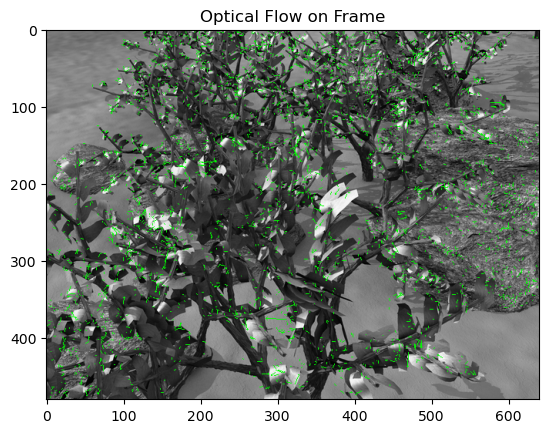

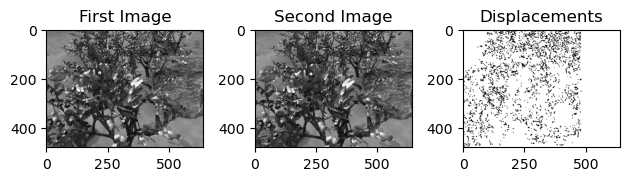

In [3]:
# Usage
optical_flow = Lucas_Kanade("Q2-1.png", "Q2-2.png")
optical_flow.process_and_display(3, 0.05)